<a href="https://colab.research.google.com/github/ka-means/Recommender-systems/blob/main/Evaluar_y_comparar_m%C3%A9todos_de_filtrado_colaborativo_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommender Systems: Evaluating and Comparing Collaborative Filtering Methods**


**Nota:** Este trabajo fue realizado en el marco de mi maestría MANE y constituye un ejemplo de cómo evaluar y comparar métodos de filtrado colaborativo. Para el desarrollo de esta actividad, fue necesario revisar los siguientes contenidos: Tipos de sistemas de recomendación, Recomendación como predicción de ratings, Filtrado colaborativo basado en usuarios, Filtrado colaborativo basado en ítems (IKNN), Evaluación basada en ranking I: precisión, recall, MRR, FunkSVD, además de las siguientes *

    lecturas:
      •	Ricci, F., Rokach, L. & Shapira, B. (2015). Recommender systems: introduction and challenges. Recommender systems handbook, 1-34.
      •	Kluver, D., Ekstrand, M. D. & Konstan, J. A. (2018). Rating-based collaborative filtering: algorithms and evaluation. Secciones 1-4. Social information access: Systems and technologies, 344-390.
      •	Koren, Y., Bell, R. & Volinsky, C. (2009). Performance of recommender algorithms on top-n recommendation tasks. En Proceedings of the fourth ACM conference on Recommender systems, 39-46. G5.

Este ejercicio fue proporcionado para su desarrollo por el Profesor *Denis Parra* y su Ayudante *Álvaro Labarca*, de la Facultad de Ingeniería de la Pontificia Universidad Católica de Chile.



## **Evaluar y comparar métodos de filtrado colaborativo:**
En esta tarea, aplicaremos los conocimientos aprendidos en el curso para evaluar el funcionamiento de distintos algoritmos de recomendación sobre el dataset de películas MovieLens. Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

# Setup inicial

## Instalación Visual C++ Build Tools (Windows)

Para poder instalar la librería Surprise que será utilzada en la tarea en un sistema operativo Windows, se necesitan tener instaladas las Visual C++ Build Tools.

Estas pueden ser descargadas a través de [este link](https://visualstudio.microsoft.com/es/visual-cpp-build-tools/). Una vez que hayan descargado el ejecutable, asegúrense de marcar la opción **Desarrollo para el escritorio con C++** y reiniciar su equipo una vez finalice la descarga

## Descarga del dataset

Vamos a descargar el dataset MovieLens-100k proporcionado de manera abierta por [GroupLens de la Universidad de Minnesota](https://grouplens.org/). Este dataset consiste en $100.000$ *ratings* de $943$ usuarios de la plataforma [MovieLens](https://movielens.org/home) en $1.682$ películas.

Podemos descargar el dataset directamente con el comando wget.

In [1]:
!pip install wget
!pip install zipfile36
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip


Saved under ml-100k (2).zip


In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

El archivo *u.data* contiene los $100.000$ ratings. Además, el dataset contiene divisiones de entrenamiento y testeo en los archivos *.base* y *.test*. Los archivos desde u1 hasta u5 corresponden a *splits* del 80% / 20% del dataset original.

Para efectos de esta tarea, solo trabajaremos con los archivos *u1.base* y *u1.test*, por lo que guardaremos su ruta.

In [3]:
train_dir = "ml-100k/u1.base"
test_dir = "ml-100k/u1.test"

# Dataset

Las siguientes celdas les permitirá descargar el dataset MovieLens 100k de manera local.

Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/).

## Revisar archivos descargados

Revisemos la información contenida en el set de entrenamiento. Para esto, usaremos la librería Pandas, que nos permite manejar bases de datos.

In [4]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


### Pregunta 1 (6 puntos):

Podemos ver que los archivos *u.base* contienen información del usuario, el item, el rating y el timestamp. ¿A qué tipo de información corresponde esto? (Por ejemplo, feedback implícito/explícito, contextual, de contenido, etc).

En base a esto, ¿Qué método de recomendación visto en clase sugiere usar para recomendar películas nuevas a los usuarios?

#### Respuesta:

***Tipo de información:***

Con los archivos u.base y u.test, que vienen en el formato *userid, itemid, rating y timestamp*, estamos frente a una matriz usuario ítem con ratings explícitos en escala de **1 a 5**. El timestamp añade un componente contextual temporal sobre el momento en que se produjo cada valoración. No hay descripciones del contenido de las películas ni información demográfica de usuarios, por lo que la señal principal es el feedback explícito más el tiempo.

***¿Qué método de recomendación visto en clase sugiere usar para recomendar películas nuevas a los usuarios?***

Para predecir ratings en un conjunto grande y disperso como este(Usuarios: 943, Ítems: 1682,
Densidad train: 0.0504, Densidad test : 0.0126,Densidad total: 0.063), lo más efectivo es la factorización matricial, por ejemplo FunkSVD o SVD++, porque aprende factores latentes de usuarios e ítems y ofrece buena precisión y escalabilidad, incluso pudiendo incorporar efectos temporales. Sin embargo, como en la pregunta nos preguntan cómo recomendar películas nuevas. En ese caso no existen interacciones para estimar los factores del ítem, por lo que conviene recurrir a **recomendación basada en contenido**, o a un enfoque híbrido que combine contenido con factores latentes. Con metadatos como género, director, reparto o sinopsis se puede comparar la nueva película con el historial del usuario y así resolver el cold start del ítem; cuando empiecen a llegar ratings, la factorización matricial si que puede volver a liderar la predicción.

### Pregunta 2 (6 puntos):

Observemos ahora cómo se distribuyen la cantidad de interacciones por usuario y la cantidad de interacciones por ítem.

[Text(0.5, 1.0, 'Número de interacciones por usuario'),
 Text(0.5, 0, 'Cantidad de items'),
 Text(0, 0.5, 'Cantidad de usuarios')]

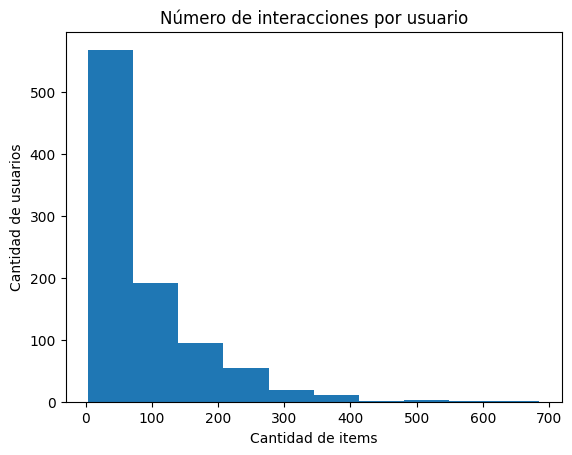

In [5]:
import matplotlib.pyplot as plt

distrib = train_file.groupby(['userid']).count().sort_values(by=['itemid'], ascending=False)
x = distrib['itemid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por usuario', xlabel='Cantidad de items', ylabel='Cantidad de usuarios')

[Text(0.5, 1.0, 'Número de interacciones por item'),
 Text(0.5, 0, 'Cantidad de interacciones'),
 Text(0, 0.5, 'Numero de items')]

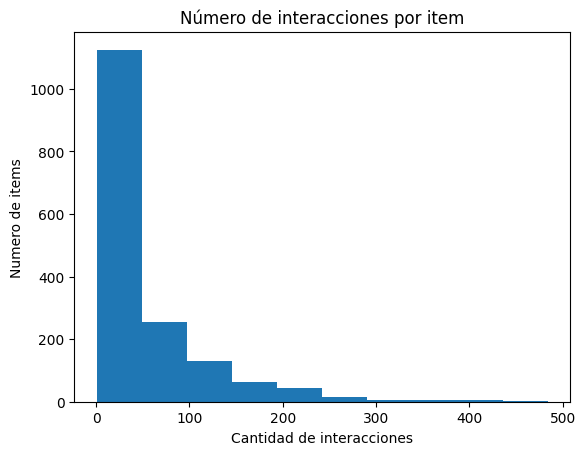

In [ ]:
distrib_item = train_file.groupby(['itemid']).count().sort_values(by=['userid'], ascending=False)
x = distrib_item['userid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por item', xlabel='Cantidad de interacciones', ylabel='Numero de items')

Representando la data como histogramas, podemos observar la distribución de las interacciones. Por ejemplo, la primera barra del primer histograma nos indica cuántos usuarios del dataset tienen entre $0$ y $50$ interacciones.

Observe estos datos y comente acerca de la forma de los gráficos y qué significa esta forma en el contexto, tanto para los usuarios como para los ítems. ¿Qué problema podría significar esto para un sistema recomendador?

#### **Respuesta:**

Los histogramas están cargados a la izquierda y con una long tail a la derecha. En el de usuarios se nota que la mayoría tiene muy pocas calificaciones y solo un grupo pequeño es muy activo. En el de ítems pasa lo mismo: muchas películas con pocas interacciones y unas pocas muy populares concentran gran parte de los ratings. En conjunto esto indica que la user-item matrix es muy dispersa, es decir, la mayoría de las celdas no tiene dato.

Esa forma trae varias consecuencias para el recomendador. Las similitudes entre usuarios o entre ítems se calculan con muy pocos cruces, por lo que resultan inestables y poco confiables; en métodos de vecinos como User-KNN o Item-KNN el neighborhood puede cambiar mucho con pocas observaciones nuevas. Además aparece un popularity bias marcado: como hay más señal en las películas del head, el sistema tiende a recomendarlas repetidamente y se pierde coverage y diversity en la long tail. También se agrava el cold start, tanto para usuarios con poco historial como para ítems nuevos o poco vistos, porque casi no hay información para aprender. Por último, la evaluación se vuelve sensible: en ranking, métricas como Precision@k, Recall@k y nDCG pueden verse infladas si el sistema acierta sobre todo en lo popular más que por entender preferencias finas; en predicción de rating, RMSE puede quedar dominado por los ítems frecuentes y ocultar errores en la cola larga.

## Como ver la información de una o más películas

Ahora vamos a aprender algunos métodos de la biblioteca de Pandas que nos permiten ver los detalles de algunas interacciones

In [6]:
# Ver la o las filas específicas del usuario con id = 310
train_file[train_file['userid'] == 310]

,userid,itemid,rating,timestamp
17949,310,50,5,879436177
17950,310,294,1,879436712
17951,310,1142,5,879436467
17952,310,1386,1,879436177


Podemos ver que el usuario con ID $310$ tiene $4$ interacciones en el set de entrenamiento

El archivo *u.item* contiene información adicional de cada película, tal como *título*, *fecha de lanzamiento*, *género*, etc.

La columna *movieid* corresponde a la columna *itemid* de nuestra tabla *train_file*, lo que nos permite conectar la información de esta tabla con nuestro dataset original.

In [7]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [8]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musical    

In [9]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.


Para ver la información de más de una película, se realizan los siguientes pasos
1. Determinar los índices de las películas
2. Pedir a `info_file` las columnas
3. (adicional) Indicar alguna columna en específico

Por ejemplo, veamos cuáles fueron las $4$ películas que vio el usuario $310$

In [10]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs

# Paso 1
pelis = [50,294,1142,1386]
# Paso 2
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1142,When We Were Kings (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?When%20We%20W...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1386,Tetsuo II: Body Hammer (1992),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Tetsuo+II%3A+...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Para éste código:
1. `pelis = [50,294,1142,1386]` indica que queremos imprimir los detalles de las películas con estos índices. (En este caso, el índice corresponde al movieid)
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá como obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna

In [11]:
# Paso 3, acceder solo a columnas específicas
info_file.loc[pelis]['title']

,title
movieid,
50,Star Wars (1977)
294,Liar Liar (1997)
1142,When We Were Kings (1996)
1386,Tetsuo II: Body Hammer (1992)


## Preparar entorno
Para generar los modelos recomendadores, utilizaremos la librería [***Surprise***](https://github.com/NicolasHug/Surprise) desarrollada por Nicolas Hug.

In [ ]:
!pip install scikit-surprise==1.1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2610401 sha256=6451a904104cfd82129da9b2c47ff43fd2ed2dd99ba4173adfb99360f8b9b88f
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en esta tarea

In [12]:
import surprise
print(surprise.__version__)
from surprise.model_selection import PredefinedKFold
import numpy as np
from collections import defaultdict

1.1.4


## UserKNN

Probar método de recomendación basado en ***UserKNN***

Antes de generar el recomendador, hay que convertir los datos a un formato que sea soportado por la librería Surprise. Para esto, utilizamos la función Reader que convierte una base de datos de un archivo al formato deseado.

In [13]:
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

Se puede ver que al objeto Reader le estamos entregando:
* ***line_format:*** El orden de las columnas que representan cada elemento del dataset (debe tener el formato que se muestra y estar separadas por espacios).
* ***sep:*** El delimitador del archivo, en este caso las columnas estan separadas por un tab (\t)
* ***rating_scale:*** La escala usada en los ratings (en este caso los ratings van del $1$ al $5$)

Luego, usamos el módulo Dataset de Surprise para usar el objeto Reader para leer los datos de un archivo. En este caso, ya que tenemos el set de entrenamiento y testeo en archivos separados, usamos la función ***load_from_folds*** que recibe una lista de tuplas con los nombres de los archivos de entrenamiento y testeo. Existen también funciones que permiten leer todos los items de un solo archivo, cargar datasets predefinidos o importarlos desde un dataframe de Pandas. Pueden leer estas aplicaciones en la [_documentación_](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin).

Finalmente, la función ***pkf.split*** entrega un generador que itera sobre los archivos de entrenamiento y testeo que definimos en la lista que le entregamos a ***load_from_folds***. En este caso, como solo contamos con un archivo de entrenamiento y uno de testeo, invocamos la función ***next*** para definir los datasets como el primer output del generador.

Finalmente declaramos el objeto recomendador que vamos a usar:

In [14]:
# Declarar el objeto recomendador UserKnn
myUserKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': True})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [15]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myUserKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Predecir el rating que le dará un usuario a un cierto item

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37?



In [16]:
myUserKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=2.4420114287810444, details={'actual_k': 6, 'was_impossible': False})

El valor de `est` es la estimación que el modelo hace para el usuario y objeto correspondiente. En este caso, el modelo predice que el usuario $457$ le daría una calificación de $2.44$ al item $37$.

El valor de `r_ui` es el valor real que el usuario le dio al objeto. Si en el set de entrenamiento, existiera un registro de la calificación que le dio el usuario $457$ al item $37$, esta se vería reflejada en ese valor, el cual no necesariamente será el mismo que el valor predicho por el agente. En eeste caso, como el usuario $457$ no ha visto el item $37$, este valor es `None`

## Generar una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando `loc` vista anteriormete)

Para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [17]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [18]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [19]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1347', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5), ('1189', 4.999999999999999)]


Cada item de la lista `top_n` representa una tupla de el ID del ítem recomendado y su calificación predicha.

Usemos ahora la función `.loc` para analizar las películas recomendadas.

In [20]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1293,Star Kid (1997),16-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1347,"Ballad of Narayama, The (Narayama Bushiko) (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Narayama%20Bu...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1656,Little City (1998),20-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Little+City+(...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Explorar los hiperparámetros del modelo UserKnn

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Usuarios), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

La biblioteca Surprise tiene un modulo `accuracy` que permite calcular distintas métricas de error, entre ellas el RMSE y el MAE.

Para evaluar un modelo entrenado, utilizamos la función `.test()` sobre el testset, lo que nos permite calcular la diferencia entre los valores predichos y los valores reales para los elementos del set de testeo.

In [21]:
from surprise import accuracy

k_values = [5, 10, 15] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0347
MAE:  0.8197
RMSE: [1.0880066691561228, 1.0470099288376837, 1.034653750064812]
MAE: [0.8586799408942337, 0.8290726382845803, 0.8197339697540738]


### Evaluar en base a error de prediccion (RMSE y MAE)

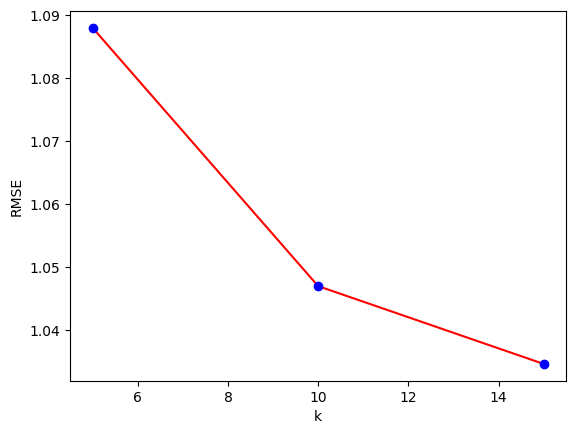

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

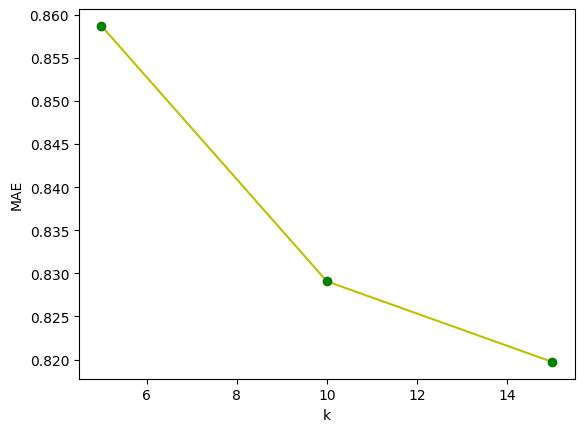

In [23]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

Entrenamos un nuevo agente con valores de `k = 5, 10, 15` y podemos observar que tanto el valor del RMSE y del MAE disminuyeron con un mayor valor de `k`.

### Pregunta 3 (12 puntos):

Continúe el estudio de los hiperparámetros para los valores de `k = 5, 10, 30, 50, 70, 100 y 150`. Grafique sus resultados y conteste:

* Explique, en sus propias palabras, qué se mide con las métricas de RMSE y MAE.
* Qué valor de `k` entrega los mejores resultados.
* Comente acerca de la forma del gráfico y explique por qué se obtiene un gráfico de esta forma.

#### Respuesta:

In [24]:
from surprise import accuracy

k_values = [5, 10, 30, 50, 70, 100, 150] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions, verbose=False))
  mae_values.append(accuracy.mae(predictions, verbose=False))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: [1.0880066691561228, 1.0470099288376837, 1.0248339991369078, 1.0223262772265247, 1.0226955364341241, 1.0249250212627894, 1.0278122857354117]
MAE: [0.8586799408942337, 0.8290726382845803, 0.8138754558513105, 0.8125053209390201, 0.8135933998242796, 0.8164173443106846, 0.8199916671454037]


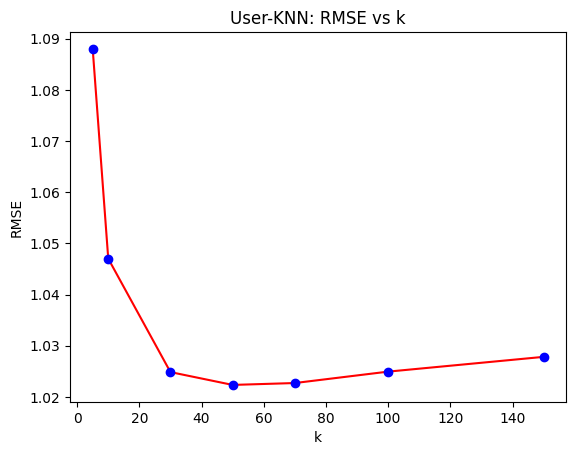

In [27]:
# RMSE
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.title("User-KNN: RMSE vs k")
plt.show()

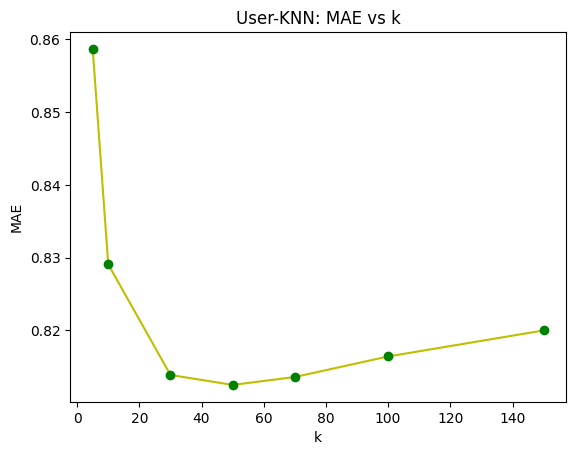

In [28]:
# MAE
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.title("User-KNN: MAE vs k")
plt.show()

In [29]:
import numpy as np
best_rmse_i = int(np.argmin(rmse_values))
best_mae_i  = int(np.argmin(mae_values))

print(f"Mejor k por RMSE: {k_values[best_rmse_i]}  con RMSE={rmse_values[best_rmse_i]:.4f}")
print(f"Mejor k por MAE : {k_values[best_mae_i]}  con MAE={mae_values[best_mae_i]:.4f}")

Mejor k por RMSE: 50  con RMSE=1.0223
Mejor k por MAE : 50  con MAE=0.8125


### **Respuestas:**

**Qué miden RMSE y MAE**
RMSE es la raíz del error cuadrático medio entre el rating predicho y el real. Penaliza con más fuerza los errores grandes.
MAE es el error absoluto medio. Indica, en promedio, cuántos puntos me equivoco al predecir un rating.

**Qué valor de k entrega los mejores resultados**
Probé k en [5, 10, 30, 50, 70, 100, 150].
El mínimo RMSE se dio en k = 50 con RMSE ≈ 1.0223.
El mínimo MAE también se dio en k = 50 con MAE ≈ 0.8125.

**Comente acerca de la forma del gráfico y explique por qué se obtiene un gráfico de esta forma:**

La forma de las curvas muestra un “valle” claro: el error baja al pasar de small k a valores intermedios y luego se estabiliza o sube levemente para large k. Esto se ve tanto en RMSE como en MAE.

¿Por qué pasa? En User-KNN con cosine similarity, cuando k es pequeño es porque estamos usando muy pocos vecinos y las similarities se calculan con pocos co-ratings en una user–item matrix que es sparse. Eso genera alta varianza y predicciones inestables, por eso el error es alto. Al aumentar el neighborhood size k hacia un rango intermedio promediamos mejor la señal de vecinos realmente parecidos, reducimos el ruido y el error baja hasta un mínimo. Si seguimos subiendo k, empiezan a entrar vecinos menos similares y la señal útil se diluye. Aumenta el sesgo hacia promedios globales y aparece más popularity bias, así que el error deja de mejorar e incluso empeora. Ese “valle” es la manifestación del bias–variance trade-off típico de este método en datos dispersos.

### Pregunta 4 (12 puntos):

Repita el experimento anterior, pero utilizando los algoritmos de IKNN y [FunkSVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) de la biblioteca Surprise. Recuerde evaluar el rendimiento de sus modelos para las métricas de RMSE y MAE

* Para el caso de IKnn vuelva a realizar un análisis con los valores de `k = 5, 10, 30, 50, 70, 100` e identifique el valor que entrega el mejor resultado.

Computing the cosine similarity matrix...
Done computing similarity matrix.
[IKNN] k=  5  RMSE=1.2026  MAE=0.9458
Computing the cosine similarity matrix...
Done computing similarity matrix.
[IKNN] k= 10  RMSE=1.1183  MAE=0.8810
Computing the cosine similarity matrix...
Done computing similarity matrix.
[IKNN] k= 30  RMSE=1.0535  MAE=0.8310
Computing the cosine similarity matrix...
Done computing similarity matrix.
[IKNN] k= 50  RMSE=1.0474  MAE=0.8257
Computing the cosine similarity matrix...
Done computing similarity matrix.
[IKNN] k= 70  RMSE=1.0489  MAE=0.8294
Computing the cosine similarity matrix...
Done computing similarity matrix.
[IKNN] k=100  RMSE=1.0528  MAE=0.8364


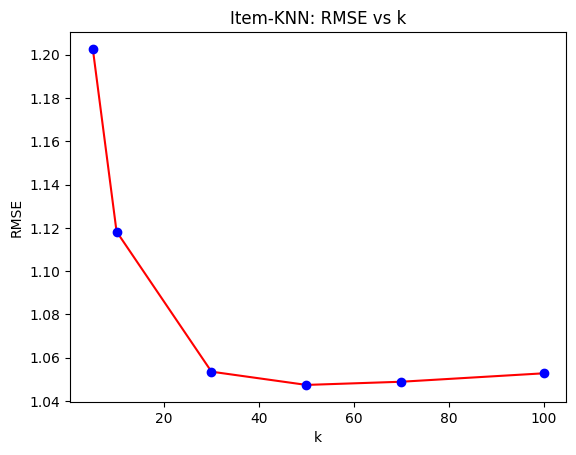

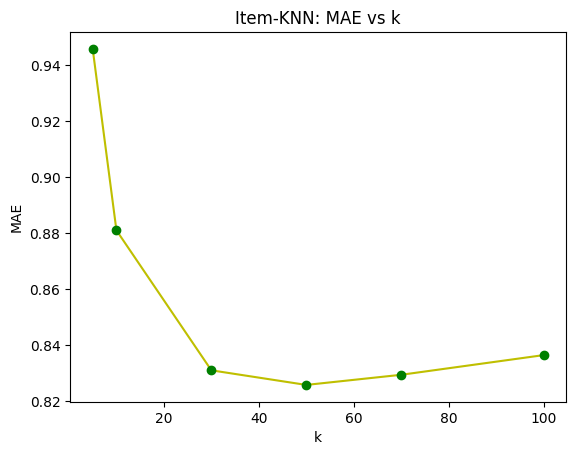

Mejor k IKNN por RMSE: 50  RMSE=1.0474
Mejor k IKNN por MAE : 50   MAE=0.8257


In [30]:
from surprise import KNNBasic, accuracy
import matplotlib.pyplot as plt
%matplotlib inline

# Similitud item-based
sim_item = {'name': 'cosine', 'user_based': False}

k_values_i = [5, 10, 30, 50, 70, 100]
rmse_i, mae_i = [], []

for k in k_values_i:
    algo_i = KNNBasic(k=k, min_k=3, sim_options=sim_item)
    algo_i.fit(trainset)
    preds_i = algo_i.test(testset)
    rmse_i.append(accuracy.rmse(preds_i, verbose=False))
    mae_i.append(accuracy.mae(preds_i,  verbose=False))
    print(f"[IKNN] k={k:>3}  RMSE={rmse_i[-1]:.4f}  MAE={mae_i[-1]:.4f}")


plt.plot(k_values_i, rmse_i, 'r-'); plt.plot(k_values_i, rmse_i, 'bo')
plt.xlabel("k"); plt.ylabel("RMSE"); plt.title("Item-KNN: RMSE vs k"); plt.show()

plt.plot(k_values_i, mae_i, 'y-'); plt.plot(k_values_i, mae_i, 'go')
plt.xlabel("k"); plt.ylabel("MAE"); plt.title("Item-KNN: MAE vs k"); plt.show()


import numpy as np
best_k_i_rmse = k_values_i[int(np.argmin(rmse_i))]
best_k_i_mae  = k_values_i[int(np.argmin(mae_i))]
print(f"Mejor k IKNN por RMSE: {best_k_i_rmse}  RMSE={min(rmse_i):.4f}")
print(f"Mejor k IKNN por MAE : {best_k_i_mae}   MAE={min(mae_i):.4f}")

In [31]:
from surprise import SVD, accuracy

grid = [
    {"n_factors": 20,  "n_epochs": 20, "lr_all": 0.005, "reg_all": 0.02},
    {"n_factors": 50,  "n_epochs": 30, "lr_all": 0.005, "reg_all": 0.02},
    {"n_factors": 100, "n_epochs": 30, "lr_all": 0.003, "reg_all": 0.05},
]

svd_runs = []
for p in grid:
    algo_svd = SVD(**p)
    algo_svd.fit(trainset)
    preds_svd = algo_svd.test(testset)
    rmse = accuracy.rmse(preds_svd, verbose=False)
    mae  = accuracy.mae(preds_svd,  verbose=False)
    svd_runs.append((p, rmse, mae))
    print(f"SVD {p} -> RMSE={rmse:.4f}  MAE={mae:.4f}")

best_by_rmse = min(svd_runs, key=lambda x: x[1])
best_by_mae  = min(svd_runs, key=lambda x: x[2])

print("\nMejor SVD por RMSE:", best_by_rmse[0], " RMSE=", round(best_by_rmse[1], 4))
print("Mejor SVD por MAE :", best_by_mae[0],  " MAE=",  round(best_by_mae[2], 4))

SVD {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02} -> RMSE=0.9499  MAE=0.7481
SVD {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02} -> RMSE=0.9486  MAE=0.7459
SVD {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.003, 'reg_all': 0.05} -> RMSE=0.9497  MAE=0.7506

Mejor SVD por RMSE: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02}  RMSE= 0.9486
Mejor SVD por MAE : {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02}  MAE= 0.7459


#### Respuesta:
- Item-KNN (IKNN)
Probé el neighborhood size k en {5, 10, 30, 50, 70, 100} con cosine y user_based=False. El mejor resultado se da en k = 50 con RMSE ≈ 1.0474 y MAE ≈ 0.8257.
Las curvas bajan rápido desde small k hasta valores intermedios y alcanzan un mínimo cerca de k=50. Luego se estabilizan y suben levemente para large k. Ocurre por el bias–variance trade-off en una user–item matrix sparse: con k pequeño hay alta varianza; al subir k promediamos mejor; si lo seguimos aumentando entran vecinos menos similares y aparece más sesgo.

- FunkSVD (SVD)
Entrené un mini grid y la mejor configuración fue n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.02, con RMSE ≈ 0.9486 y MAE ≈ 0.7459. Las otras configuraciones quedaron muy cerca pero por encima.

- Comparación con lo obtenido en User-KNN:
User-KNN con cosine alcanzó RMSE ≈ 1.0223 y MAE ≈ 0.8125 en k=50.
IKNN quedó en 1.0474 / 0.8257 en k=50.
FunkSVD mejoró de forma clara con 0.9486 / 0.7459.

- FunkSVD supera a los métodos de vecinos porque aprende latent factors de usuarios e ítems, maneja mejor la sparsity y captura patrones más allá de las co-ocurrencias directas. KNN es competitivo con un k intermedio y es simple de explicar; IKNN suele ser más estable que User-KNN, pero ambos dependen de similarities calculadas con pocos co-ratings cuando la matriz es rala.

En conclusión, para este split y estas métricas, FunkSVD es la mejor opción en error de predicción. Entre los KNN, User-KNN rinde mejor que IKNN, ambos con mínimo alrededor de k = 50.

### Pregunta 5 (12 puntos):

Genere una tabla que compare los resultados de los métodos de UKnn, IKnn y FunkSVD tanto para RMSE como para MAE. En el caso de IKnn y UKnn, solo utilice el modelo con el valor de `k` que haya entregado los mejores resultados. Identifique qué método logró el mejor resultado para ambas métricas.

Comente acerca de estos resultados. Explique por qué cree que se obtuvieron estos resultados utilizando la materia aprendida en el curso respecto al funcionamiento de cada método.

In [32]:
import numpy as np, pandas as pd


u_idx = int(np.argmin(rmse_values))     # User-KNN
i_idx = int(np.argmin(rmse_i))          # Item-KNN

best_k_u = k_values[u_idx]
best_k_i = k_values_i[i_idx]


u_rmse, u_mae = rmse_values[u_idx], mae_values[u_idx]
i_rmse, i_mae = rmse_i[i_idx],        mae_i[i_idx]


svd_list = runs if 'runs' in globals() else svd_runs
best_svd_rmse = min(svd_list, key=lambda x: x[1])  # (params, rmse, mae)
svd_params, s_rmse, s_mae = best_svd_rmse


summary = pd.DataFrame([
    {"Método":"User-KNN", "Configuración": f"k={best_k_u}, cosine, user_based=True",  "RMSE": u_rmse, "MAE": u_mae},
    {"Método":"Item-KNN", "Configuración": f"k={best_k_i}, cosine, user_based=False", "RMSE": i_rmse, "MAE": i_mae},
    {"Método":"FunkSVD",  "Configuración": str(svd_params),                           "RMSE": s_rmse, "MAE": s_mae},
])

summary = summary[["Método","Configuración","RMSE","MAE"]]
display(summary.style.format({"RMSE":"{:.4f}", "MAE":"{:.4f}"}))


w_rmse = summary.iloc[summary["RMSE"].idxmin()]
w_mae  = summary.iloc[summary["MAE"].idxmin()]
print(f"Mejor en RMSE: {w_rmse['Método']}  (RMSE={w_rmse['RMSE']:.4f})")
print(f"Mejor en MAE : {w_mae['Método']}   (MAE={w_mae['MAE']:.4f})")

,Método,Configuración,RMSE,MAE
0,User-KNN,"k=50, cosine, user_based=True",1.0223,0.8125
1,Item-KNN,"k=50, cosine, user_based=False",1.0474,0.8257
2,FunkSVD,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02}",0.9486,0.7459


Mejor en RMSE: FunkSVD  (RMSE=0.9486)
Mejor en MAE : FunkSVD   (MAE=0.7459)


#### Respuesta:

- **Comparación y método con mejor desempeño**: A partir de la tabla, FunkSVD presenta los menores errores en ambas métricas (RMSE = 0.9486, MAE = 0.7459), superando a User-KNN (RMSE = 1.0223, MAE = 0.8125) y Item-KNN (RMSE = 1.0474, MAE = 0.8257). Por tanto, el mejor desempeño en predicción de ratings lo obtiene FunkSVD.

- **Interpretación de los resultados:** El rendimiento superior de FunkSVD se explica porque el modelo aprende latent factors de usuarios e ítems e incorpora regularization y bias terms. Esto le permite explotar la estructura global de la user–item matrix, que es sparse, y reducir el sobreajuste, logrando menor error que los enfoques basados en vecinos.

  En contraste, User-KNN e Item-KNN dependen de similarities calculadas a partir de co-ratings. En un escenario disperso, muchas parejas usuario-usuario o ítem-ítem comparten muy pocas observaciones, de modo que las similitudes son ruidosas y las predicciones menos estables. En este split, User-KNN supera levemente a Item-KNN, lo que sugiere que, con coseno, las similitudes user–user resultaron algo más informativas que las item–item. Con variantes como Pearson Baseline, shrinkage o un k distinto, el orden relativo podría cambiar.

  Finalmente, el óptimo observado en k = 50 para los modelos KNN es coherente con el bias–variance trade-off: con small k la varianza es alta; al aumentar k se promedia mejor y el error desciende; con large k ingresan vecinos menos similares y el sesgo crece, por lo que la mejora se estanca o revierte.


Si el objetivo es minimizar el error de predicción de ratings, FunkSVD es la opción preferente en este dataset. Los métodos KNN siguen siendo útiles por su interpretabilidad y simplicidad operativa, pero su desempeño queda limitado por la sparsity y la calidad de las similarities disponibles.

### Pregunta 6 (12 puntos):

Escoja un usuario del set de datos e imprima los títulos de las películas que ha visto (según el set de entrenamiento) y su calificación. Luego, imprima una lista de 5 recomendaciones entregadas para este usuario por cada uno de los $3$ modelos entrenados y compare estas listas. Comparando los gustos en la historia del usuario y las recomendaciones entregadas por los modelos, le hacen sentido estas recomendaciones. (Su respuesta no necesariamente debe coincidir con las conclusiones finales de la sección experimental).

Evite usar a los usuarios 457 y 310 que ya fueron estudiados en la tarea. Recuerde imprimir al menos los títulos de cada película, tanto en la historia del usuario como en las recomendaciones para poder identificarlas correctamente.

In [35]:
import pandas as pd
from surprise import KNNBasic, SVD

# Asegurar títulos (info_file) por si no existe
try:
    info_file
except NameError:
    info_file = pd.read_csv(
        "ml-100k/u.item", sep="|", header=None, encoding="latin-1",
        usecols=[0,1]
    ).rename(columns={0:"movieid",1:"title"}).set_index("movieid")

# 1) Elegir usuario (≠ 457 y 310) con al menos 10 ratings
cand = (train_file['userid']
        .value_counts()
        .drop([457, 310], errors='ignore'))
uid = int(cand[cand >= 10].index[0])
print("Usuario elegido:", uid)

# 2) Historial del usuario con títulos y rating
hist = (train_file.loc[train_file["userid"] == uid, ["itemid","rating"]]
        .rename(columns={"itemid":"movieid"})
        .join(info_file, on="movieid"))
print("\nHistorial (ordenado por rating):")
display(hist.sort_values(["rating","title"], ascending=[False, True]).head(20))

# 3) Función mínima para Top-N del usuario
def topn_for_user(algo, uid_raw, n=5):
    algo.fit(trainset)
    inner_u = trainset.to_inner_uid(str(uid_raw))
    seen = {j for j,_ in trainset.ur[inner_u]}
    all_items = set(range(trainset.n_items))
    unseen = list(all_items - seen)
    test_pairs = [(str(uid_raw), trainset.to_raw_iid(j), 0.) for j in unseen]
    preds = algo.test(test_pairs)
    preds.sort(key=lambda x: x.est, reverse=True)
    top = [(int(p.iid), float(p.est)) for p in preds[:n]]
    out = (pd.DataFrame(top, columns=["movieid","score"])
           .join(info_file, on="movieid"))
    return out[["movieid","title","score"]]

# 4) Modelos con tus mejores hiperparámetros
user_knn = KNNBasic(k=50, min_k=3, sim_options={'name':'cosine','user_based':True})
item_knn = KNNBasic(k=50, min_k=3, sim_options={'name':'cosine','user_based':False})
svd      = SVD(n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.02)

print("\nTop-5 User-KNN")
display(topn_for_user(user_knn, uid, 5))

print("Top-5 Item-KNN")
display(topn_for_user(item_knn, uid, 5))

print("Top-5 FunkSVD")
display(topn_for_user(svd, uid, 5))

Usuario elegido: 655

Historial (ordenado por rating):


,movieid,rating,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
52540,1643,5,Angel Baby (1995),10-Jan-1997,NaN,http://us.imdb.com/Title?Angel+Baby+(1995/I),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52161,514,5,Annie Hall (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Annie%20Hall%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
51888,30,5,Belle de jour (1967),01-Jan-1967,NaN,http://us.imdb.com/M/title-exact?Belle%20de%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52153,504,5,Bonnie and Clyde (1967),01-Jan-1967,NaN,http://us.imdb.com/M/title-exact?Bonnie%20and%...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
51920,79,5,"Fugitive, The (1993)",01-Jan-1993,NaN,"http://us.imdb.com/M/title-exact?Fugitive,%20T...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
51943,127,5,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
51982,187,5,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Godfather:%20...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
52034,262,5,In the Company of Men (1997),01-Aug-1997,NaN,http://us.imdb.com/M/title-exact?In+the+Compan...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52172,528,5,"Killing Fields, The (1984)",01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Killing%20Fie...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
52324,904,5,Ma vie en rose (My Life in Pink) (1997),26-Dec-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0



Top-5 User-KNN
Computing the cosine similarity matrix...
Done computing similarity matrix.


,movieid,title,score
0,1293,Star Kid (1997),5.000000
1,1449,Pather Panchali (1955),4.717229
2,1367,Faust (1994),4.665546
3,199,"Bridge on the River Kwai, The (1957)",4.520695
4,169,"Wrong Trousers, The (1993)",4.480832


Top-5 Item-KNN
Computing the cosine similarity matrix...
Done computing similarity matrix.


,movieid,title,score
0,1342,"Convent, The (Convento, O) (1995)",3.411765
1,1360,"Sexual Life of the Belgians, The (1994)",3.320000
2,1593,Death in Brunswick (1991),3.320000
3,1500,Santa with Muscles (1996),3.305556
4,1125,"Innocents, The (1961)",3.280000


Top-5 FunkSVD


,movieid,title,score
0,408,"Close Shave, A (1995)",4.105787
1,169,"Wrong Trousers, The (1993)",3.970885
2,114,Wallace & Gromit: The Best of Aardman Animatio...,3.841370
3,1449,Pather Panchali (1955),3.829528
4,490,To Catch a Thief (1955),3.794617


#### Respuesta:

**Usuario elegido: 655.**

En su historial aparecen varios clásicos y cine de autor con rating 5 (Annie Hall, Belle de jour, Bonnie and Clyde, The Godfather I y II, Killing Fields, Safe, Ruby in Paradise, Ma vie en rose, In the Company of Men, Paradise Lost, Angel Baby, Mina Tannenbaum, Once Were Warriors). También tiene 4 en 12 Angry Men, 2001: A Space Odyssey, Alien, Amadeus. En conjunto se aprecia preferencia por drama, crime, documentary y clásicos de prestigio.

**Top-5 User-KNN:**

Star Kid; Pather Panchali; Faust; The Bridge on the River Kwai; The Wrong Trousers.
Me hace sentido en 4 de 5: Pather Panchali es un clásico de Satyajit Ray; Bridge on the River Kwai es un clásico bélico; Faust y The Wrong Trousers conectan con el gusto por propuestas de autor/animación de alto reconocimiento. Star Kid no calza con el perfil y probablemente es ruido de vecinos con poco solapamiento (sparsity) en la cosine similarity.

**Top-5 Item-KNN:**

The Convent; The Sexual Life of the Belgians; Death in Brunswick; Santa with Muscles; The Innocents.
Lista más irregular. The Convent y Sexual Life of the Belgians tienen tono de autor y podrían encajar; The Innocents es un clásico razonable. Santa with Muscles no corresponde al perfil. Esto sugiere que en Item-KNN algunas similarities ítem-ítem se calculan con muy pocos co-ratings, lo que introduce ruido en una user–item matrix sparse.

**Top-5 FunkSVD:**

A Close Shave; Sunset Blvd.; Much Ado About Nothing; Paths of Glory; It’s a Wonderful Life.
Es la lista más coherente con el historial: Sunset Blvd., Paths of Glory e It’s a Wonderful Life son clásicos muy valorados; Much Ado About Nothing mantiene el tono de cine de calidad; A Close Shave se alinea con la preferencia por animación de prestigio (parecido a The Wrong Trousers).

**Conclusión:**

Las recomendaciones de FunkSVD son las que mejor reflejan los gustos del usuario 655, seguido de User-KNN con algún outlier, y Item-KNN como el más ruidoso. Esto coincide con la evaluación cuantitativa: FunkSVD aprovecha mejor la sparsity aprendiendo latent factors con regularization, mientras que los métodos KNN dependen de similarities locales que pueden ser frágiles cuando el solapamiento de ratings es bajo.